In [1]:
# ===============================
# Imports & Setup
# ===============================
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim import Adam
from sklearn.model_selection import train_test_split

torch.manual_seed(1234)
np.random.seed(1234)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def piecewise_function(x):
    noise = np.random.normal(0, 0.1)
    if x < 0.:
        return 5.0 + np.sin(x) + np.sin(2.*x) + np.sin(3.*x) + np.sin(4.*x) + noise
    else:
        return np.cos(10.*x) + noise

def piecewise_exact(x):
    if x < 0.:
        return 5.0 + np.sin(x) + np.sin(2.*x) + np.sin(3.*x) + np.sin(4.*x)
    else:
        return np.cos(10.*x)


In [3]:
# ===============================
# Model Definition
# ===============================
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedForwardNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

In [4]:
# ===============================
# Data Preparation
# ===============================
a, b = -np.pi, np.pi
N_total = 200
x_all = np.linspace(a, b, N_total)
y_all = np.array([piecewise_function(xi) for xi in x_all])

x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.3)

x_train_tensor = torch.tensor(x_train.reshape(-1, 1), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
x_test_tensor = torch.tensor(x_test.reshape(-1, 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

In [ ]:
# ===============================
# Training
# ===============================
model = FeedForwardNN(input_dim=1, hidden_dim=100, output_dim=1)
loss_fn = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

train_losses, test_losses = [], []
epochs = 3000

for epoch in range(epochs):
    model.train()
    y_pred = model(x_train_tensor)
    loss = loss_fn(y_pred, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        test_pred = model(x_test_tensor)
        test_loss = loss_fn(test_pred, y_test_tensor)

    train_losses.append(loss.item())
    test_losses.append(test_loss.item())

    if (epoch + 1) % 300 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4e} - Test Loss: {test_loss.item():.4e}")



Epoch 300/3000 - Train Loss: 4.2817e-01 - Test Loss: 6.1904e-01
Epoch 600/3000 - Train Loss: 2.2800e-01 - Test Loss: 3.4850e-01
Epoch 900/3000 - Train Loss: 1.5025e-01 - Test Loss: 2.8550e-01
Epoch 1200/3000 - Train Loss: 1.0232e-01 - Test Loss: 2.4631e-01
Epoch 1500/3000 - Train Loss: 7.2074e-02 - Test Loss: 2.1255e-01
Epoch 1800/3000 - Train Loss: 5.2539e-02 - Test Loss: 1.9976e-01
Epoch 2100/3000 - Train Loss: 4.0363e-02 - Test Loss: 1.6723e-01
Epoch 2400/3000 - Train Loss: 3.0183e-02 - Test Loss: 1.6322e-01
Epoch 2700/3000 - Train Loss: 2.5063e-02 - Test Loss: 1.5123e-01
Epoch 3000/3000 - Train Loss: 2.1020e-02 - Test Loss: 1.4984e-01


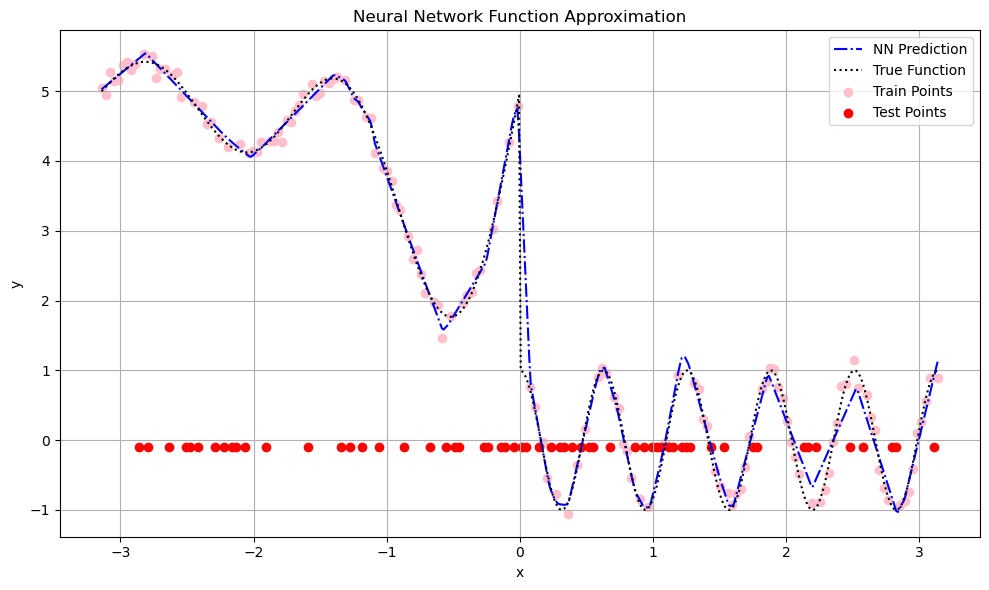

In [6]:
# ===============================
# Visualization
# ===============================
x_plot = np.linspace(a, b, 500)
x_plot_tensor = torch.tensor(x_plot.reshape(-1, 1), dtype=torch.float32)
with torch.no_grad():
    y_nn = model(x_plot_tensor).numpy()
y_true = np.array([piecewise_exact(xi) for xi in x_plot])

plt.figure(figsize=(10, 6))
plt.plot(x_plot, y_nn, label='NN Prediction', linestyle='-.', color='blue')
plt.plot(x_plot, y_true, label='True Function', linestyle=':', color='black')
plt.scatter(x_train, y_train, color='pink', label='Train Points')
plt.scatter(x_test, -0.1 * np.ones_like(x_test), color='red', label='Test Points')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Neural Network Function Approximation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()